# Main Program file for Cancer Predictive Model (Jupyter Notebook Version)
## By: Group CL_04

### Importing Libraries

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os, random, shutil
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from PIL import Image

### Dividing Dataset (70% training, 30% testing)

In [2]:
def img_train_test_split(root_dir, classes_dir, test_ratio):
    '''
    This function splits a folder with subfolders into train and test datasets
    :param root_dir: a string corresponding to the file path of the folder of subfolders of images
    :param classes_dir: a list of strings of subfolder names
    :param test_ratio: a float of the ratio of test dataset to train dataset
    :return: None
    '''

    for cls in classes_dir:
        # create a new train and test directory for cls
        os.makedirs(root_dir + 'train/' + cls)
        os.makedirs(root_dir + 'test/' + cls)

        # get pathname of cls
        src = root_dir + cls

        # split the filenames into chosen training and testing ratio
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                   [int(len(allFileNames) * (1 - test_ratio))])

        # copy images into new train folder for cls subfolder
        for name in train_FileNames:
            shutil.copy(root_dir + cls + '/' + name, root_dir + 'train/' + cls)

        # copy images into new test folder for cls subfolder
        for name in test_FileNames:
            shutil.copy(root_dir + cls + '/' + name, root_dir + 'test/' + cls)
    return None

In [3]:
classes_dir = ['MSIMUT_JPEG', 'MSS_JPEG']
test_ratio = 0.3

In [4]:
# root_dir: filepath of coad_msi_mss with '/' at the back
root_dir = '/Users/vionnietan/Desktop/trial_dataset/coad_msi_mss/'
# root_dir = '/Users/elainealverina/Desktop/trial_dataset/'

#root_dir = '/Users/elainealverina/Documents/GitHub/FIT3164-LocalRepo/FIT3164/cancer dataset/coad_msi_mss/'
#root_dir = '/Users/vionnietan/Desktop/cancer dataset/coad_msi_mss/'

In [5]:
img_train_test_split(root_dir, classes_dir, test_ratio)

### Data Augmentation and Normalization

In [6]:
data_transformation_train = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
data_transformation_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

root_dir_train = '/Users/vionnietan/Desktop/trial_dataset/coad_msi_mss/train'
#root_dir_train = '/Users/elainealverina/Documents/GitHub/FIT3164-LocalRepo/FIT3164/cancer dataset/coad_msi_mss/train'
#root_dir_train = '/Users/elainealverina/Desktop/trial_dataset/train'

root_dir_test = '/Users/vionnietan/Desktop/trial_dataset/coad_msi_mss/test'
#root_dir_test = '/Users/elainealverina/Documents/GitHub/FIT3164-LocalRepo/FIT3164/cancer dataset/coad_msi_mss/test'
#root_dir_test = '/Users/elainealverina/Desktop/trial_dataset/test'

In [7]:
train_image_dataset = datasets.ImageFolder(root = root_dir_train, transform=data_transformation_train)
test_image_dataset = datasets.ImageFolder(root = root_dir_test, transform=data_transformation_test)

### Prepare DataLoader

In [8]:
trainloader = DataLoader(train_image_dataset, batch_size=128, shuffle=True)
testloader = DataLoader(test_image_dataset, batch_size=128, shuffle=True)

### Data Visualization (Display some images)

In [11]:
class_names = trainloader.dataset.classes

def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        if i < 5:
            plt.subplot(1, 6, i+1, xticks=[], yticks=[])
            
            # Convert to from tensor to numpy
            # Take its transpose because
            # In ResNet implementation, the format for input is n_channels * n_height * n_width (!and not n_height * n_width * n_channels)
            image = image.numpy().transpose((1, 2, 0))  # Set axes
            
            # Images were normalised earlier.
            # To show the image denormalise the images
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            
            image = image*std + mean
            image = np.clip(image, 0.,1.)
            plt.imshow(image)
            
            colour = 'green' if preds[i] == labels[i] else 'red'
            
            plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
            plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=colour)
        
    plt.tight_layout()
    plt.show()

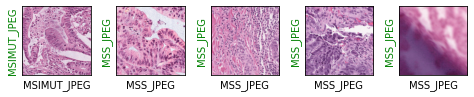

In [12]:
images, labels = next(iter(trainloader))

# Since predictions are not available for training data yet
# Labels are used in place of predictions
show_images(images, labels, labels)

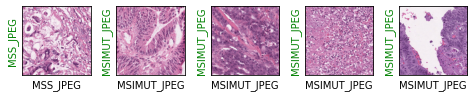

In [13]:
# Show Images of Testing Data
images_test, labels_test = next(iter(testloader))
show_images(images_test,labels_test, labels_test)

### Creating Model - Load resnet18

In [14]:
# Switch to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18 = models.resnet18(pretrained=True)
#print(resnet18)

In [15]:
# Freeze parameters so we don't backprop through them
for param in resnet18.parameters():
    param.requires_grad = False
    
# Classifier architecture to put on top of resnet18
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()

# Using Adam Optimizer
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.0001)
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
def show_preds():
    resnet18.eval()    # set to evaluation mode
    images, labels = next(iter(testloader))
    outputs = resnet18(images)
    _ , preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

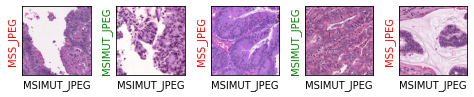

In [34]:
show_preds()

### Training Model

In [28]:
def train(epochs):
    print('Started training...')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e+1}/{epochs}')
        print('='*20)
        
        train_loss = 0
        
        resnet18.train()   # set to training mode
        
        for train_step, (images, labels) in enumerate(trainloader):
            
            # Refresh optimizer and set gradients to zero
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            if train_step % 20 == 0:
                print('\nEvaluating at step:', train_step)
                acc = 0.
                val_loss = 0.
                resnet18.eval()
                
                for val_step, (images, labels) in enumerate(testloader):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    _ , preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).numpy())
                    
                val_loss /= (val_step + 1)
                acc /= len(test_image_dataset)
                print(f'Val loss = {val_loss:.4f}, Accuracy = {acc:.4f}')
                # show_preds()
                
                resnet18.train()
                
                #if acc > 0.97:
                    #print('\nPerformance condition satisifed, hence stopping...')
                    #return
                
        train_loss /= (train_step+1)
        print(f'\nTraining loss = {train_loss:.4f}')

In [29]:
train(epochs=10)

Started training...
Starting epoch 1/10

Evaluating at step: 0
Val loss = 0.8610, Accuracy = 17.0000

Training loss = 0.8739
Starting epoch 2/10

Evaluating at step: 0
Val loss = 0.8492, Accuracy = 17.0000

Training loss = 0.8779
Starting epoch 3/10


KeyboardInterrupt: 

In [16]:
epochs = 5
steps = 0
running_loss = 0
print_every = 1
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = resnet18.forward(inputs)
        loss = loss_fn(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            resnet18.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = resnet18.forward(inputs)
                    batch_loss = loss_fn(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            resnet18.train()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/5.. Train loss: 1.277.. Test loss: 1.068.. Test accuracy: 0.300
Epoch 2/5.. Train loss: 1.240.. Test loss: 1.065.. Test accuracy: 0.333
Epoch 3/5.. Train loss: 1.211.. Test loss: 1.064.. Test accuracy: 0.333
Epoch 4/5.. Train loss: 1.175.. Test loss: 1.065.. Test accuracy: 0.367
Epoch 5/5.. Train loss: 1.160.. Test loss: 1.065.. Test accuracy: 0.400


In [35]:
n_epochs = 10
print_every = 1
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(trainloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(trainloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = resnet18(data_)
        loss = loss_fn(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        resnet18.eval()
        for data_t, target_t in (testloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = resnet18(data_t)
            loss_t = loss_fn(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(testloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(resnet18.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    resnet18.train()

Epoch 1

Epoch [1/10], Step [0/1], Loss: 0.9031

train-loss: 0.9031, train-acc: 42.8571
validation loss: 0.8362, validation acc: 53.3333

Improvement-Detected, save-model
Epoch 2

Epoch [2/10], Step [0/1], Loss: 0.8695

train-loss: 0.8863, train-acc: 48.5714
validation loss: 0.8311, validation acc: 53.3333

Improvement-Detected, save-model
Epoch 3

Epoch [3/10], Step [0/1], Loss: 0.8583

train-loss: 0.8770, train-acc: 48.5714
validation loss: 0.8262, validation acc: 53.3333

Improvement-Detected, save-model
Epoch 4

Epoch [4/10], Step [0/1], Loss: 0.8233

train-loss: 0.8635, train-acc: 50.0000
validation loss: 0.8218, validation acc: 53.3333

Improvement-Detected, save-model
Epoch 5

Epoch [5/10], Step [0/1], Loss: 0.8364

train-loss: 0.8581, train-acc: 47.1429
validation loss: 0.8177, validation acc: 50.0000

Improvement-Detected, save-model
Epoch 6

Epoch [6/10], Step [0/1], Loss: 0.8248

train-loss: 0.8526, train-acc: 48.5714
validation loss: 0.8138, validation acc: 50.0000

Improve

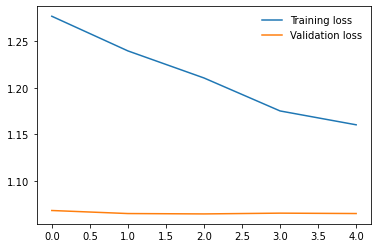

In [19]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [32]:
torch.save(resnet18, '/Users/vionnietan/Desktop/resnet18.pth')